In [10]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50


In [11]:
MODEL_PATH = '../data/models/final_model.pth' 
RESULTS_PATH = '../results'
os.makedirs(RESULTS_PATH, exist_ok=True)

#  Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Define transforms for test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
# Load test dataset
test_dir = os.path.join(DATASET_PATH, 'test')
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [13]:
# Get class names
class_names = test_dataset.classes
print(f"Found {len(class_names)} classes: {class_names}")


Found 22 classes: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [ ]:

# Initialize model with the  number of classes
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Load saved model parameters
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Model loaded from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Continuing with an untrained model for testing purposes.")

model.to(device)
model.eval() 

c:\Users\25800714\SkinScan\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\25800714\SkinScan\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Error loading model: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Evaluating model...

Overall Accuracy: 12.23%

Classification Report:
                     precision    recall  f1-score   support

               Acne       0.00      0.00      0.00        65
  Actinic_Keratosis       0.00      0.00      0.00        83
      Benign_tumors       0.00      0.00      0.00       121
            Bullous       0.00      0.00      0.00        55
        Candidiasis       0.00      0.00      0.00        27
       DrugEruption       0.00      0.00      0.00        61
             Eczema       0.00      0.00      0.00       112
 Infestations_Bites       0.00      0.00      0.00        60
             Lichen       0.00      0.00      0.00        61
              Lupus       0.00      0.00      0.00        34
              Moles       0.00      0.00      0.00        40
          Psoriasis       0.00      0.00      0.00        88
            Rosacea       0.00      0.00      0.00        28
  Seborrh_Keratoses       0.00      0.00      0.00        51
         SkinC

c:\Users\25800714\SkinScan\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\25800714\SkinScan\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\25800714\SkinScan\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\2580071

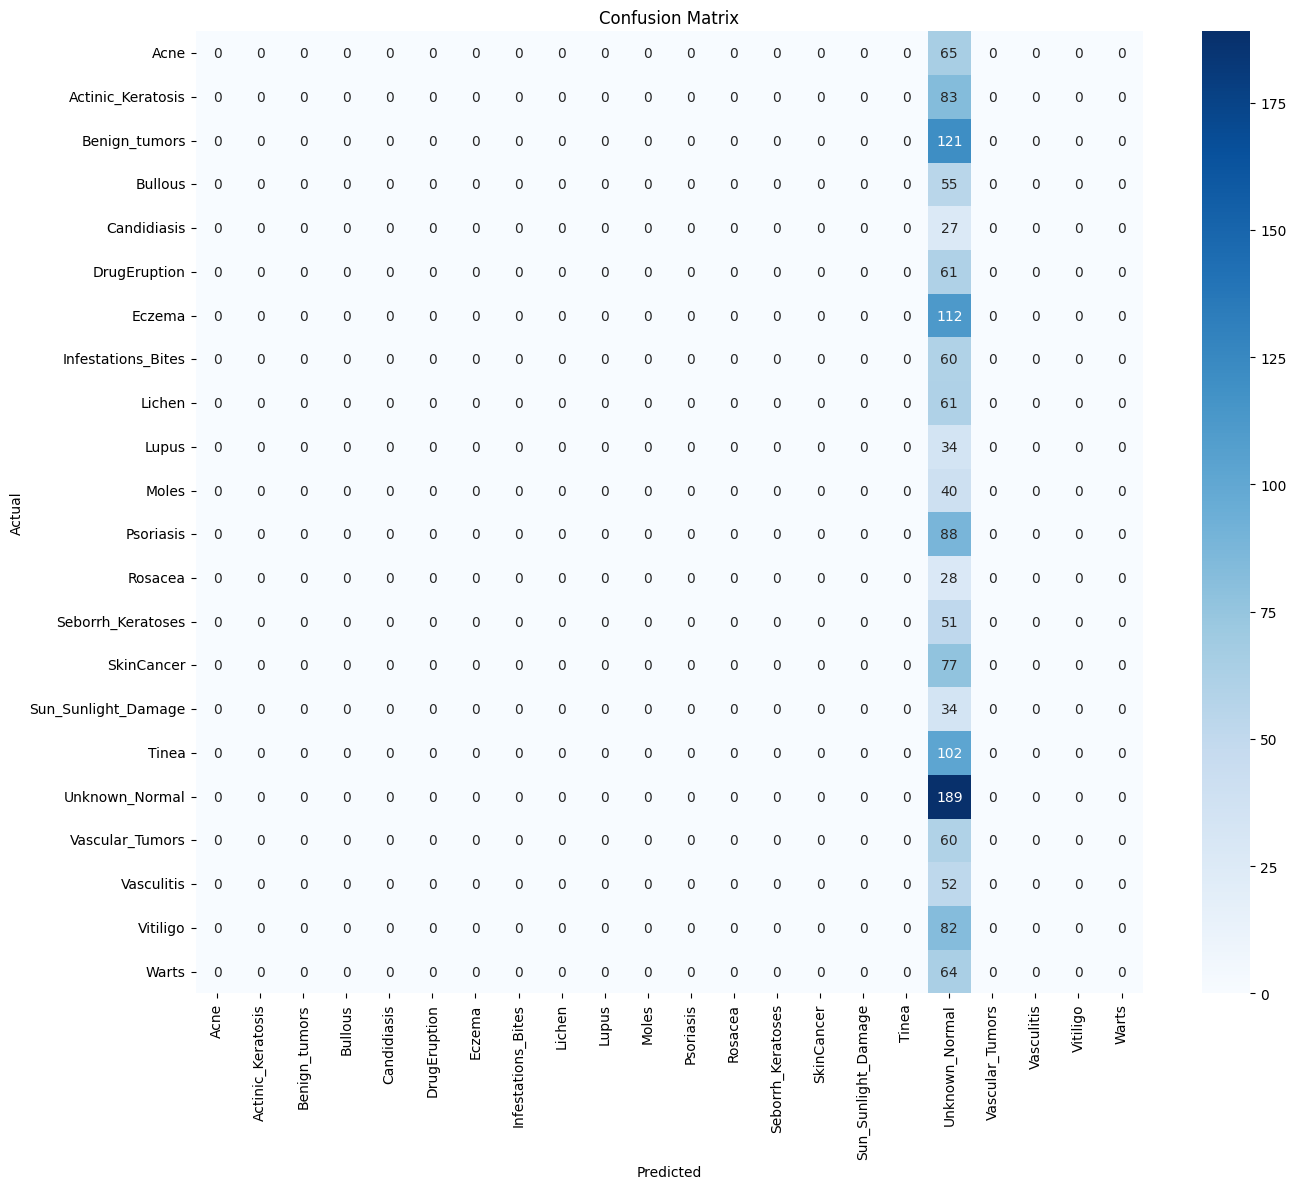

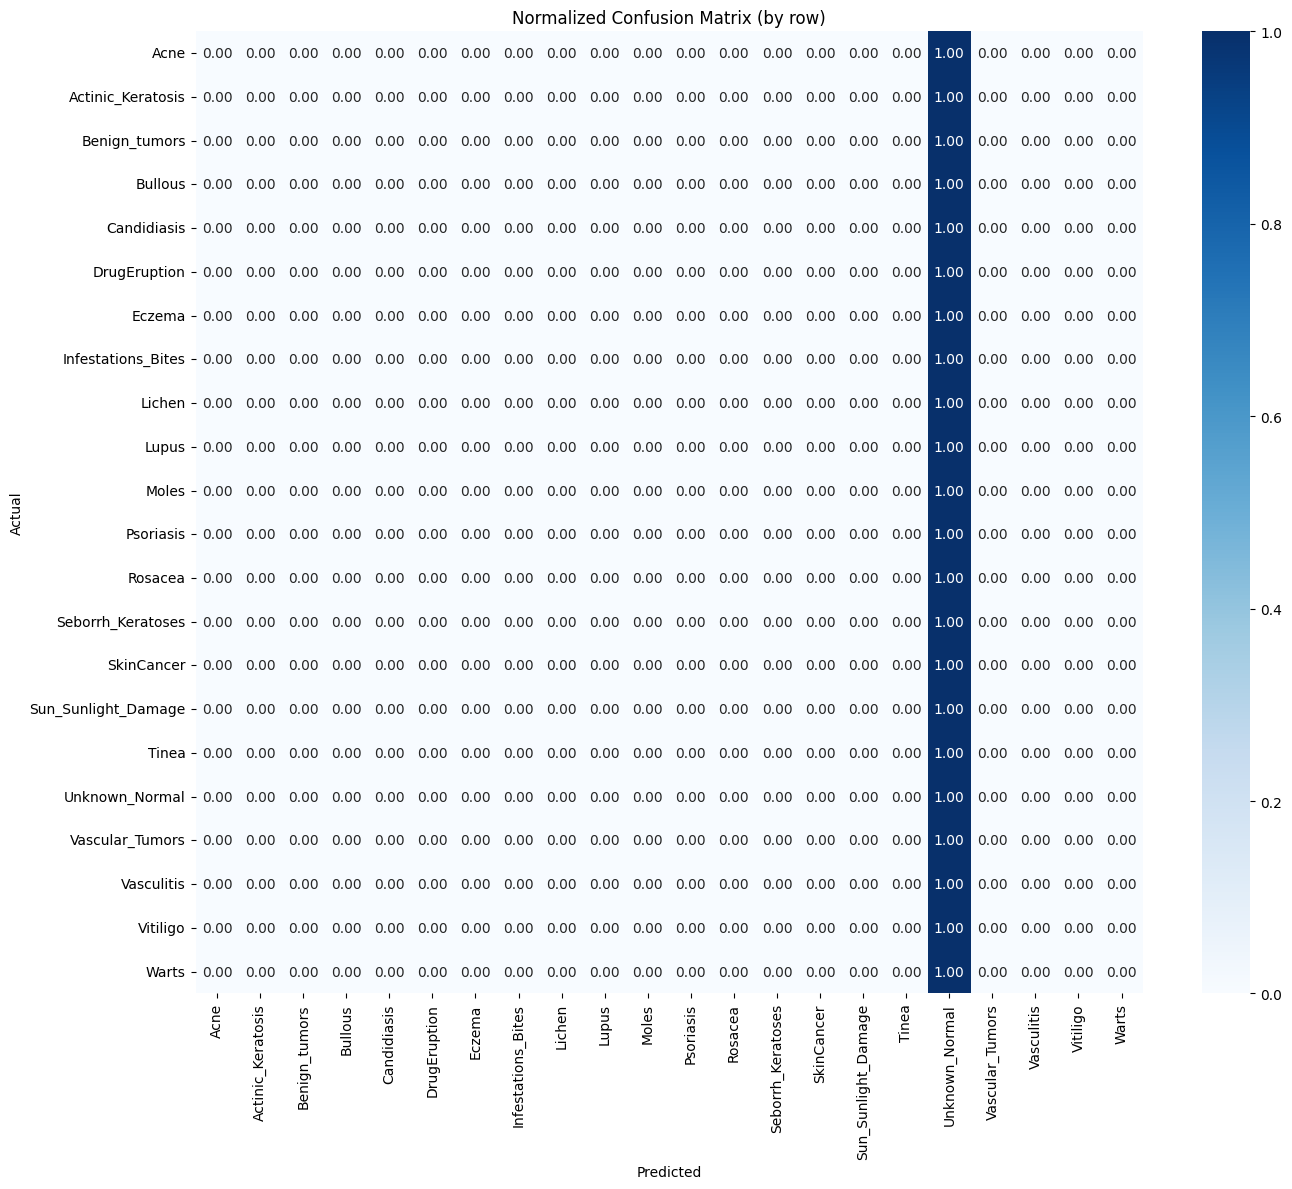

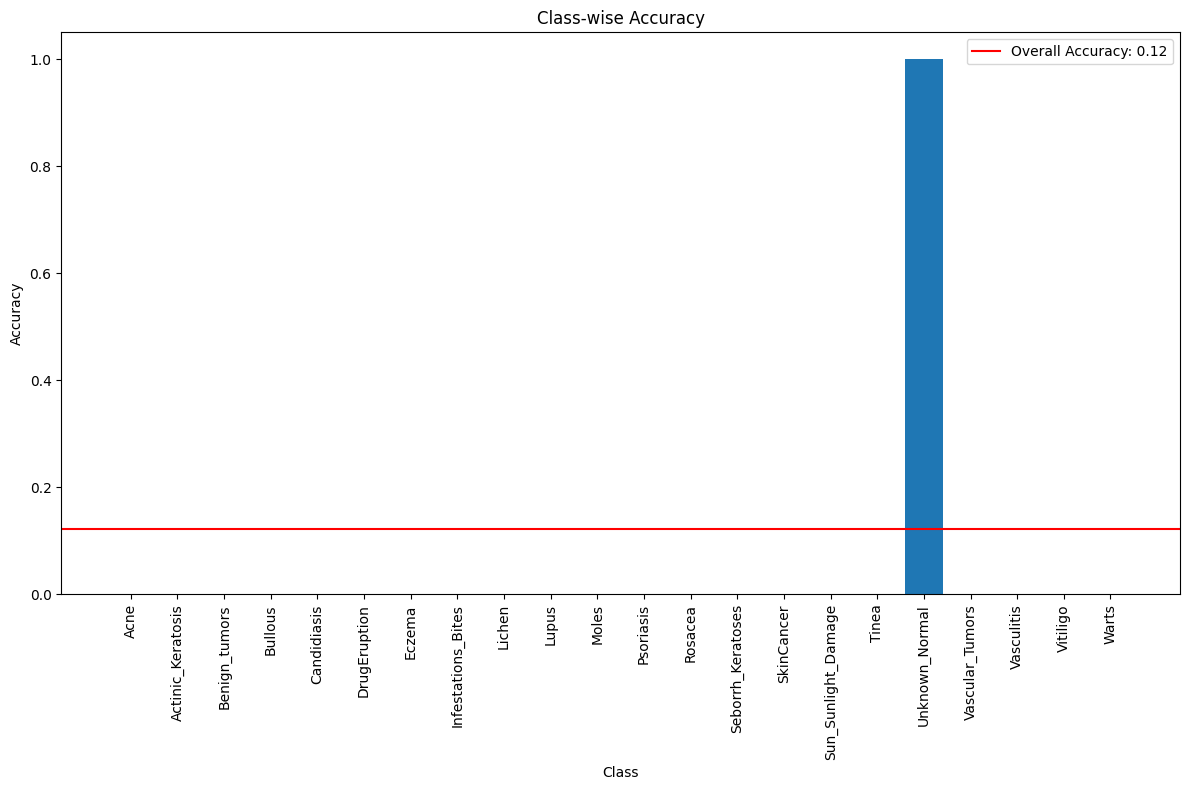

In [15]:


# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    y_scores = []
    
    # Track correct predictions and total samples for each class
    class_correct = {i: 0 for i in range(len(class_names))}
    class_total = {i: 0 for i in range(len(class_names))} 
    
    # Store incorrect examples for analysis
    incorrect_examples = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Record prediction scores (probabilities)
            scores = F.softmax(outputs, dim=1)
            
            # Extend lists for later analysis
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(scores.cpu().numpy())
            
            # Update class-wise accuracy tracking
            for i in range(len(labels)):
                label = labels[i].item()
                prediction = preds[i].item()
                class_total[label] += 1
                if label == prediction:
                    class_correct[label] += 1
                else:
                    # Store incorrect examples (input tensor, true label, predicted label)
                    incorrect_examples.append((
                        inputs[i].cpu(),
                        label,
                        prediction,
                        scores[i].cpu().numpy()
                    ))
    
    # Calculate overall accuracy
    accuracy = sum(class_correct.values()) / sum(class_total.values())
    
    # Calculate class-wise accuracy
    class_accuracy = {class_names[i]: class_correct[i]/class_total[i] 
                      if class_total[i] > 0 else 0 
                      for i in range(len(class_names))}
    
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'class_accuracy': class_accuracy,
        'incorrect_examples': incorrect_examples
    }

# Evaluate the model
print("Evaluating model...")
results = evaluate_model(model, test_loader, device)

# Print overall accuracy
print(f"\nOverall Accuracy: {results['accuracy']*100:.2f}%")

# Classification report
print("\nClassification Report:")
report = classification_report(results['y_true'], results['y_pred'], target_names=class_names, output_dict=True)
print(classification_report(results['y_true'], results['y_pred'], target_names=class_names))

# Convert report to dataframe for easier handling
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(RESULTS_PATH, 'classification_report.csv'))

# Confusion Matrix
cm = confusion_matrix(results['y_true'], results['y_pred'])
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix.png'))
plt.show()

# Normalize confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix (by row)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix_normalized.png'))
plt.show()

# Plot class-wise accuracy
class_acc = results['class_accuracy']
plt.figure(figsize=(12, 8))
plt.bar(class_acc.keys(), class_acc.values())
plt.axhline(y=results['accuracy'], color='r', linestyle='-', label=f'Overall Accuracy: {results["accuracy"]:.2f}')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(RESULTS_PATH, 'class_wise_accuracy.png'))
plt.show()



Visualizing top confident incorrect predictions:


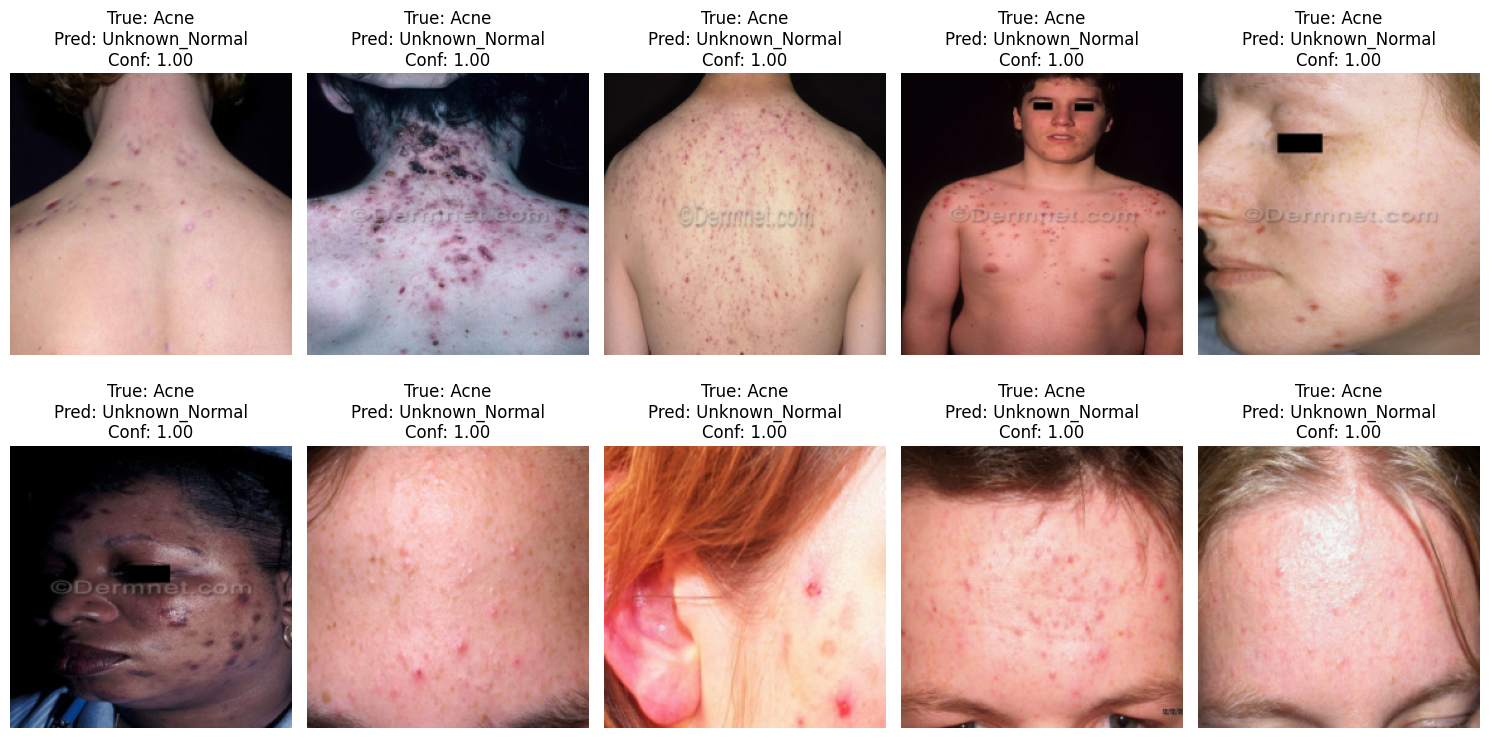

In [20]:

# Function to visualize incorrect predictions
def plot_incorrect_predictions(incorrect_examples, class_names, num_to_show=10):
    """
    Visualize incorrect predictions
    """
    if not incorrect_examples:
        print("No incorrect predictions to show.")
        return
    
    # Sort by confidence of wrong prediction (most confident mistakes first)
    sorted_examples = sorted(incorrect_examples, 
                            key=lambda x: x[3][x[2]], 
                            reverse=True)
    
    # Take the top num_to_show examples
    examples_to_plot = sorted_examples[:num_to_show]
    
    # Plot the examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()
    
    # Inverse normalization function to display images properly
    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])
    
    for i, (img_tensor, true_label, pred_label, scores) in enumerate(examples_to_plot):
        if i >= len(axes):
            break
            
        # Convert tensor to image
        img_tensor = inv_normalize(img_tensor)
        img = img_tensor.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {scores[pred_label]:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'incorrect_predictions.png'))
    plt.show()

# Visualize incorrect predictions
print("\nVisualizing top confident incorrect predictions:")
plot_incorrect_predictions(results['incorrect_examples'], class_names)




Analyzing most commonly confused classes:


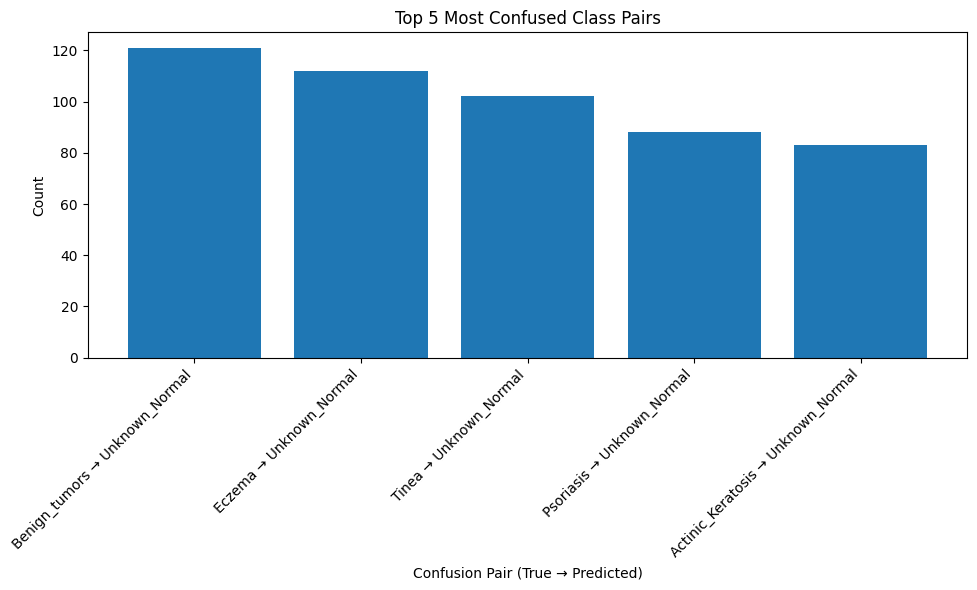

True: Benign_tumors, Predicted: Unknown_Normal, Count: 121
True: Eczema, Predicted: Unknown_Normal, Count: 112
True: Tinea, Predicted: Unknown_Normal, Count: 102
True: Psoriasis, Predicted: Unknown_Normal, Count: 88
True: Actinic_Keratosis, Predicted: Unknown_Normal, Count: 83


<Figure size 1200x800 with 0 Axes>

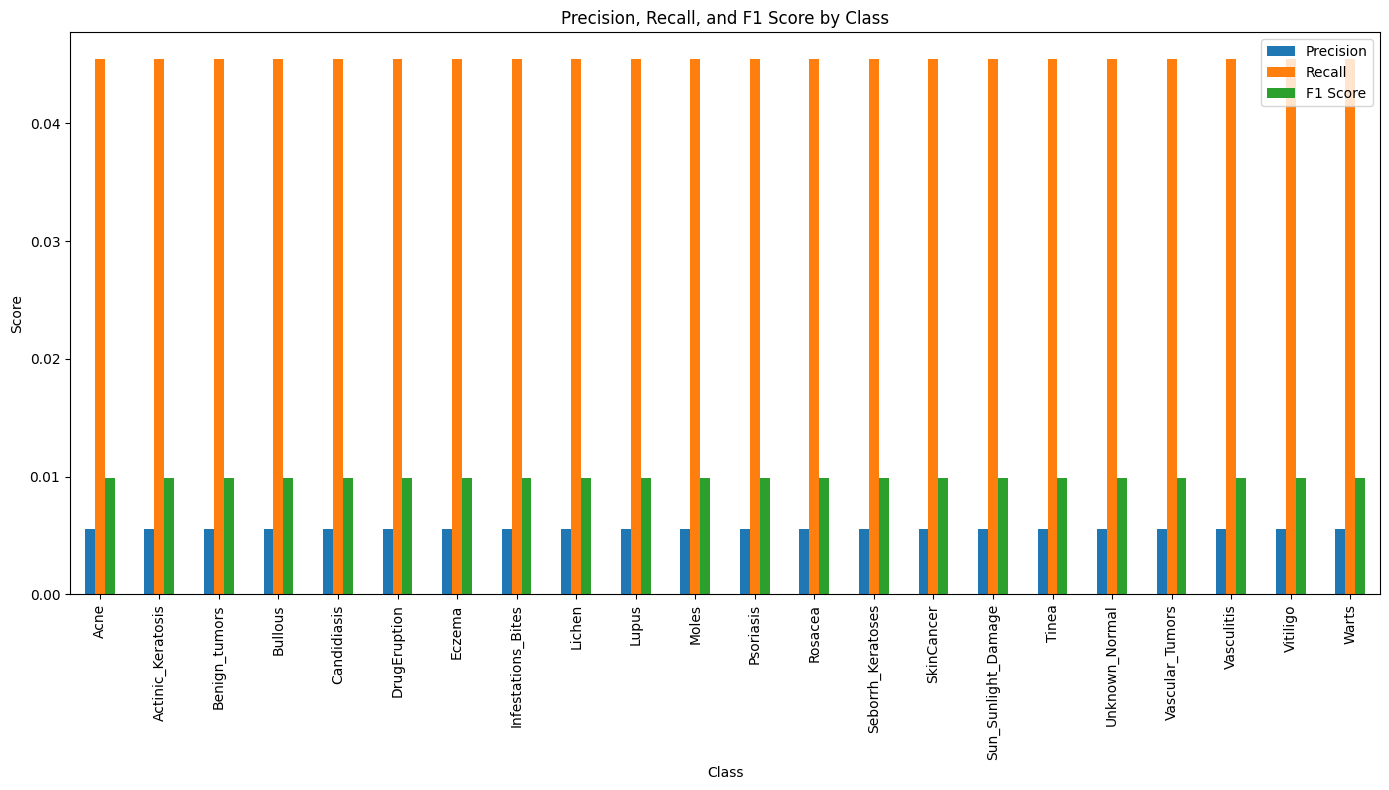


Model evaluation complete. Results saved to: ../results


In [18]:
# This function visualizes confusion between specific classes
def plot_class_confusion(y_true, y_pred, class_names, top_n=5):
    """
    Find the most commonly confused class pairs and visualize them
    """
    # Initialize confusion count dictionary
    confusion_pairs = {}
    
    # Count confusion instances
    for true_idx, pred_idx in zip(y_true, y_pred):
        if true_idx != pred_idx:
            pair = (class_names[true_idx], class_names[pred_idx])
            confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    # Sort by frequency
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    
    # Get top N pairs
    top_pairs = sorted_pairs[:top_n]
    
    # Plot
    plt.figure(figsize=(10, 6))
    pairs = [f"{true} → {pred}" for (true, pred), _ in top_pairs]
    counts = [count for _, count in top_pairs]
    
    plt.bar(pairs, counts)
    plt.xlabel('Confusion Pair (True → Predicted)')
    plt.ylabel('Count')
    plt.title(f'Top {top_n} Most Confused Class Pairs')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'top_confused_classes.png'))
    plt.show()
    
    return top_pairs

# Plot top confused class pairs
print("\nAnalyzing most commonly confused classes:")
confused_pairs = plot_class_confusion(results['y_true'], results['y_pred'], class_names)
for (true_class, pred_class), count in confused_pairs:
    print(f"True: {true_class}, Predicted: {pred_class}, Count: {count}")

# Calculate and plot precision, recall, and F1 score for each class
precision = {}
recall = {}
f1_score = {}

for i, class_name in enumerate(class_names):
    precision[class_name] = report['macro avg']['precision'] 
    recall[class_name] = report['macro avg']['recall']
    f1_score[class_name] = report['macro avg']['f1-score']

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Plot precision, recall, and F1 score
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Precision, Recall, and F1 Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'precision_recall_f1.png'))
plt.show()

print("\nModel evaluation complete. Results saved to:", RESULTS_PATH)